# DSI - Project 2: Regression Challenge (Ames Housing Data)

### Project Description:

Welcome the Kaggle challenge for Project 2! As part of a successful submission for Project 2, we will expect you to make at least one  submissions towards this regression challenge.

In this challenge, you will use the well known Ames housing data to create a regression model that predicts the price of houses in Ames, IA. You should feel free to use any and all features that are present in this dataset.

#### Goal : 
To predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.

#### Evaluation : 
Kaggle leaderboard standings will be determined by root mean squared error .

### Data Description:

There are three files:
- train.csv -- this data contains all of the training data for your model.
    -The target variable (SalePrice) is removed from the test set!
- test.csv -- this data contains the test data for your model. You will feed this data into your regression model to make predictions.
- sample_sub_reg.csv -- An example of a correctly formatted submission for this challenge (with a random number provided as predictions for SalePrice. Please ensure that your submission to Kaggle matches this format.

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt

import pickle

%matplotlib inline

In [136]:
#Data Cleaning

In [137]:
ames_raw = './datasets/train.csv'
df = pd.read_csv(ames_raw)
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


### Taking a look at the Id and PID Features

In [138]:
df.Id.nunique()

2051

In [139]:
df.PID.nunique()

2051

In [140]:
df.shape

(2051, 81)

Id and PID appear to be functionally redundant as unique identifiers, 
so I'll drop PID and set the dataframe to index on Id.

In [141]:
df.set_index('Id', inplace=True)
df.drop(columns='PID', inplace=True)

In [142]:
#Next I'll take a look to see how many null values need to be addressed.
df.isnull().sum().sort_values(ascending=False).head(30)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Qual        114
Garage Yr Blt      114
Garage Cond        114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
Bsmt Cond           55
Bsmt Qual           55
BsmtFin Type 1      55
Mas Vnr Area        22
Mas Vnr Type        22
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Area          1
Garage Cars          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
3Ssn Porch           0
Screen Porch         0
Full Bath            0
Half Bath            0
dtype: int64

## Dealing with the higghest null values

Pool QC is mostly null, so I'll take a look at the values it does have.

In [143]:
df['Pool QC'].value_counts()

Gd    4
TA    2
Fa    2
Ex    1
Name: Pool QC, dtype: int64

Pool QC doesn't contain any values for a missing pool, so I will fill those nulls as 'NA' to signify that these are properties that do not have pools.

In [144]:
df['Pool QC'].fillna('NA', inplace=True)

Now that the nulls in Pool QC have been filled, I'll take a look at the values in Misc Feature next.

In [145]:
df['Misc Feature'].value_counts()

Shed    56
Gar2     4
Othr     3
Elev     1
TenC     1
Name: Misc Feature, dtype: int64

Since these are uncommon features in a home, I think it's reasonable to again impute a value of 'NA' for the nulls here.

In [146]:
df['Misc Feature'].fillna('NA', inplace=True)

Fence and Alley are two remaining features with mostly null values. The categorical values for Fence in the provided data dictionary aren't entirely clear so I'm not confident about their consistent ability to influence price. 

However, the mere existence of a fence could be relevant and it's easy to classify, so I'll convert this column to a binary one where a value of 1 indicates that a property has a fence and a 0 indicates that the property has no fence.

In [147]:
fence_quality = ['MnPrv', 'GdPrv', 'GdWo', 'MnWw']
for quality in fence_quality:
    df.Fence = df.Fence.str.replace(quality, '1')
df.Fence.fillna(0, inplace=True)
df.Fence = df.Fence.apply(lambda x: int(x))
df.Fence.head(8)

Id
109     0
544     0
153     0
318     0
255     0
138     0
2827    0
145     1
Name: Fence, dtype: int64


The Fence column is now numeric and indicates whether or not the property has a fence. I'll run a similar process on Alley to convert that feature into a binary one rather than a categorical one. 

All properties with an alley, regardless of material, will have an Alley value of 1, and all other properties will have their null value filled with a 0.

In [148]:
alley_quality = ['Grvl', 'Pave']
for quality in alley_quality:
    df.Alley = df.Alley.str.replace(quality, '1')
df.Alley.fillna(0, inplace=True)
df.Alley = df.Alley.apply(lambda x: int(x))
df.Alley.head(8)

Id
109     0
544     0
153     0
318     0
255     0
138     0
2827    0
145     0
Name: Alley, dtype: int64


Another feature with plenty of null values is Fireplace Qu. In my opinion, the categorical descriptions for Fireplace Qu in the provided data dictionary lack precision. 

Since we already have a numeric feature (Fireplaces) indicating how many fireplaces are in each property, I feel comfortable dropping Fireplace Qu from the dataset.

In [149]:
df.drop(columns='Fireplace Qu', inplace=True)

### Garage Nulls

Next I'll focus on the garage-related features. First I'll create a function that can quickly display which properties have null values in a particular column.

In [150]:
def has_null(col):
    null_mask = (df[col].isnull())
    print(df[null_mask])
    return

has_null('Garage Cars')

      MS SubClass MS Zoning  Lot Frontage  Lot Area Street  Alley Lot Shape  \
Id                                                                            
2237           70        RM          50.0      9060   Pave      0       Reg   

     Land Contour Utilities Lot Config  ... Screen Porch Pool Area Pool QC  \
Id                                      ...                                  
2237          Lvl    AllPub     Inside  ...            0         0      NA   

     Fence Misc Feature Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  
Id                                                                        
2237     1           NA        0        3     2007        WD      150909  

[1 rows x 78 columns]


I'll take a closer look at property 2237.

In [151]:
df.loc[2237, df.columns.str.contains('Garage')]

Garage Type      Detchd
Garage Yr Blt       NaN
Garage Finish       NaN
Garage Cars         NaN
Garage Area         NaN
Garage Qual         NaN
Garage Cond         NaN
Name: 2237, dtype: object

This is the only property that is missing values for Garage Cars and Garage Area, and its Garage Type value indicates that it does have a garage. 

Since it's only one property and it has no other garage information from which to infer, I'm going to drop this row.

In [152]:
df.drop(index=2237, inplace=True)

Next I want to see if the same properties are missing all the various garage values.

In [153]:
df[df['Garage Type'].isnull() &
   df['Garage Yr Blt'].isnull() &
   df['Garage Finish'].isnull() &
   df['Garage Qual'].isnull() &
   df['Garage Cond'].isnull()]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2243,190,C (all),75.0,8250,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,6,2007,WD,119600
330,160,RM,21.0,1476,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,3,2010,WD,76000
2278,20,RL,70.0,8402,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,12,2007,New,147000
2235,50,RM,50.0,7288,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,9,2007,WD,129850
2084,30,RL,58.0,9098,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,7,2007,WD,86000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,90,RL,94.0,9400,Pave,0,Reg,Low,AllPub,Corner,...,0,0,NA,0,NA,0,4,2010,WD,139000
2880,30,C (all),69.0,12366,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,10,2006,WD,51689
2628,90,RL,75.0,8512,Pave,0,Reg,Lvl,AllPub,Corner,...,0,0,NA,0,NA,0,9,2006,WD,119000


Since the same 113 properties are missing garage-related values, we can infer that these properties do not have garages. I will fill those values as 'NA' so they will be appropriately categorized when I one-hot encode the garage features. 

However, I first want to check the years that garages were built because values of 0 in that numeric column will distort the rest of the column's values. I will compare the years that the garages were built with the years the properties were built to see how many garages were built after the original property construction.

In [154]:
def compare_garage_year(data):
    counter = 0
    for row in data.index:
        if df.loc[row]['Garage Yr Blt'] - df.loc[row]['Year Built'] > 0:
            counter += 1
    return counter

compare_garage_year(df)

362

According to my compare_garage_year function, 362 properties have garages with different build years than the property itself. 

That number is higher than I would like, but since we already have so many other features for the garages, 362 is still low enough that I feel comfortable dropping the Garage Yr Blt column. 

I will also fill the null values of the four remaining garage features, then check the cleaning progress.

In [155]:
df.drop(columns = 'Garage Yr Blt', inplace=True)

df['Garage Type'].fillna('NA', inplace=True)
df['Garage Finish'].fillna('NA', inplace=True)
df['Garage Qual'].fillna('NA', inplace=True)
df['Garage Cond'].fillna('NA', inplace=True)

### Basement Nulls
First I want to see how many basement nulls I need to address.

In [156]:
basement_cols = df.columns[df.columns.str.contains('Bsmt')]

df[basement_cols].isnull().sum()

Bsmt Qual         55
Bsmt Cond         55
Bsmt Exposure     58
BsmtFin Type 1    55
BsmtFin SF 1       1
BsmtFin Type 2    56
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
dtype: int64

Next, I want to find the one property that is null for BsmtFin Type 1.

In [157]:
has_null('BsmtFin SF 1')

      MS SubClass MS Zoning  Lot Frontage  Lot Area Street  Alley Lot Shape  \
Id                                                                            
1342           20        RM          99.0      5940   Pave      0       IR1   

     Land Contour Utilities Lot Config  ... Screen Porch Pool Area Pool QC  \
Id                                      ...                                  
1342          Lvl    AllPub        FR3  ...            0         0      NA   

     Fence Misc Feature Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  
Id                                                                        
1342     1           NA        0        4     2008      ConLD      79000  

[1 rows x 77 columns]


In [158]:
df.loc[1342, basement_cols]

Bsmt Qual         NaN
Bsmt Cond         NaN
Bsmt Exposure     NaN
BsmtFin Type 1    NaN
BsmtFin SF 1      NaN
BsmtFin Type 2    NaN
BsmtFin SF 2      NaN
Bsmt Unf SF       NaN
Total Bsmt SF     NaN
Bsmt Full Bath    NaN
Bsmt Half Bath    NaN
Name: 1342, dtype: object

In [159]:
df.loc[1342, 'Total Bsmt SF'] = 0
df.loc[1342, 'Bsmt Full Bath'] = 0
df.loc[1342, 'Bsmt Half Bath'] = 0
df.loc[1342, 'Bsmt Unf SF'] = 0
df.loc[1342, 'BsmtFin SF 2'] = 0
df.loc[1342, 'BsmtFin SF 1'] = 0
df.loc[1342, 'Bsmt Qual'] = 'NA'
df.loc[1342, 'Bsmt Cond'] = 'NA'
df.loc[1342, 'Bsmt Exposure'] = 'NA'
df.loc[1342, 'BsmtFin Type 1'] = 'NA'
df.loc[1342, 'BsmtFin Type 2'] = 'NA'

There should be one more property with a null value for Bsmt Full Bath.

In [160]:
has_null('Bsmt Full Bath')

      MS SubClass MS Zoning  Lot Frontage  Lot Area Street  Alley Lot Shape  \
Id                                                                            
1498           20        RL         123.0     47007   Pave      0       IR1   

     Land Contour Utilities Lot Config  ... Screen Porch Pool Area Pool QC  \
Id                                      ...                                  
1498          Lvl    AllPub     Inside  ...            0         0      NA   

     Fence Misc Feature Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  
Id                                                                        
1498     0           NA        0        7     2008        WD      284700  

[1 rows x 77 columns]


In [161]:
df.loc[1498, basement_cols]

Bsmt Qual         NaN
Bsmt Cond         NaN
Bsmt Exposure     NaN
BsmtFin Type 1    NaN
BsmtFin SF 1      0.0
BsmtFin Type 2    NaN
BsmtFin SF 2      0.0
Bsmt Unf SF       0.0
Total Bsmt SF     0.0
Bsmt Full Bath    NaN
Bsmt Half Bath    NaN
Name: 1498, dtype: object

Since it's the only property left in the dataset with missing basement bathroom values, I will manually set those values to 0, but then I will start programatically filling in the rest of the dataset's basement nulls.

In [162]:
df.loc[1498, 'Bsmt Full Bath'] = 0
df.loc[1498, 'Bsmt Half Bath'] = 0

I want to get a quick look at whether all the properties with those null basement values have any existing values that could be overwritten when I pass the properties through a function.

In [163]:
no_basement = (df['Total Bsmt SF'] == 0)

df[no_basement][basement_cols]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
Id,,,,,,,,,,,
807,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
811,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
781,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
888,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
1554,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2740,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2242,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2745,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
84,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0


Since there don't seem to be any stray values for these features, I'll write a function to fill all the null categories and pass the dataframe through it.

In [164]:
def fill_basement_nulls(data):
    for row in data.index:
        if data.loc[row, 'Total Bsmt SF'] == 0:
            data.loc[row, 'Bsmt Qual'] = 'NA'
            data.loc[row, 'Bsmt Cond'] = 'NA'
            data.loc[row, 'Bsmt Exposure'] = 'NA'
            data.loc[row, 'BsmtFin Type 1'] = 'NA'
            data.loc[row, 'BsmtFin Type 2'] = 'NA'
    return

fill_basement_nulls(df)

In [165]:
df[basement_cols].isnull().sum()

Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     3
BsmtFin Type 1    0
BsmtFin SF 1      0
BsmtFin Type 2    1
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
dtype: int64

To address these last four basement nulls, I'll first figure out which properties have Bsmt Exposure nulls.

In [166]:
has_null('Bsmt Exposure')

      MS SubClass MS Zoning  Lot Frontage  Lot Area Street  Alley Lot Shape  \
Id                                                                            
1797           60        FV          81.0     10411   Pave      0       Reg   
67             20        RL          73.0      8987   Pave      0       Reg   
2780           60        RL          65.0     14006   Pave      0       IR1   

     Land Contour Utilities Lot Config  ... Screen Porch Pool Area Pool QC  \
Id                                      ...                                  
1797          Lvl    AllPub     Corner  ...            0         0      NA   
67            Lvl    AllPub     Inside  ...            0         0      NA   
2780          Lvl    AllPub     Inside  ...            0         0      NA   

     Fence Misc Feature Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  
Id                                                                        
1797     0           NA        0        7     2007        New  

I have no reasonable way of inferring the Bsmt Exposure for those three properties, and because it's only three properties I believe I can drop them from the training dataset without any adverse effects on the model.

In [167]:
df.drop(index=1797, inplace=True)
df.drop(index=67, inplace=True)
df.drop(index=2780, inplace=True)

In [168]:
has_null('BsmtFin Type 2')

     MS SubClass MS Zoning  Lot Frontage  Lot Area Street  Alley Lot Shape  \
Id                                                                           
445           20        RL          85.0     10655   Pave      0       IR1   

    Land Contour Utilities Lot Config  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
445          Lvl    AllPub     Inside  ...            0         0      NA   

    Fence Misc Feature Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  
Id                                                                       
445     0           NA        0       10     2009        WD      284000  

[1 rows x 77 columns]


I want to take a closer look at this property.

In [169]:
df.loc[445, basement_cols]

Bsmt Qual             Gd
Bsmt Cond             TA
Bsmt Exposure         No
BsmtFin Type 1       GLQ
BsmtFin SF 1      1124.0
BsmtFin Type 2       NaN
BsmtFin SF 2       479.0
Bsmt Unf SF       1603.0
Total Bsmt SF     3206.0
Bsmt Full Bath       1.0
Bsmt Half Bath       0.0
Name: 445, dtype: object

This property has a large basement and half of it is finished, with a substantial portion rated as good living quarters. We can assume that the BsmtFin Type 2 is not also good living quarters, otherwise it would be grouped in with BsmtFin Type 1. 

Since we can see that the space is 479 square feet, and we can reasonably infer that the large living quarters contains the basement's only bathroom, we can also infer that the space is a rec room rather than another living quarters. 

Therefore, I will impute the value for an average rec room.

In [170]:
df.loc[445, 'BsmtFin Type 2'] = 'Rec'

And with that, I'm done cleaning the basement null values.

### Last Miscellaneous Nulls

In [171]:
df.isnull().sum().sort_values(ascending=False).head()

Lot Frontage     330
Mas Vnr Type      22
Mas Vnr Area      22
MS SubClass        0
Bedroom AbvGr      0
dtype: int64

First I'll verify that the same 22 properties are missing both Mas Vnr Area and Mas Vnr Area.

In [172]:
df[df['Mas Vnr Area'].isnull() &
   df['Mas Vnr Type'].isnull()]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2393,60,RL,103.0,12867,Pave,0,IR1,Lvl,AllPub,Corner,...,0,0,NA,0,NA,0,7,2006,New,344133
2383,20,RL,107.0,13891,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,9,2006,New,465000
539,20,RL,67.0,10083,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,8,2009,WD,184900
518,20,FV,90.0,7993,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,10,2009,New,225000
2824,20,RL,75.0,8050,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,4,2006,WD,117250
1800,60,FV,112.0,12217,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,12,2007,New,310013
1455,60,RL,75.0,9473,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,3,2008,WD,237000
1120,20,RL,87.0,10037,Pave,0,Reg,Lvl,AllPub,Corner,...,0,0,NA,0,NA,0,8,2008,WD,247000
1841,120,FV,35.0,4274,Pave,1,IR1,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,11,2007,New,199900


Since it is the same 22 properties, I'll take a look at the rest of the Mas Vnr Type feature.

In [173]:
df['Mas Vnr Type'].value_counts()

None       1216
BrkFace     628
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

ince most properties have no masonry work, I'll impute the mode of 'None' and 0 for Mas Vnr Type and

In [174]:
df['Mas Vnr Area'].fillna(0, inplace=True)
df['Mas Vnr Type'].fillna('None', inplace=True)

df.isnull().sum().sort_values(ascending=False).head()

Lot Frontage    330
MS SubClass       0
Half Bath         0
Garage Type       0
Fireplaces        0
dtype: int64

We have too many nulls for Lot Frontage to drop those properties from our dataset, but not enough nulls to drop the feature entirely. Since it is unlikely that a property truly has zero linear feet of Lot Frontage I will impute the mean value.

In [175]:
df['Lot Frontage'].fillna(value=df['Lot Frontage'].mean(), inplace=True)

In [176]:
df.isnull().sum().sum()

0

The data is clean so I'll export it as a new CSV file designated train_clean.csv.

In [177]:
df.to_csv('./datasets/train_clean.csv')

# EDA & Initial Modeling

In [178]:
ames_clean = './datasets/train_clean.csv'
df = pd.read_csv(ames_clean, index_col='Id', keep_default_na=False)
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
109,60,RL,69.059406,13517,Pave,0,IR1,Lvl,AllPub,CulDSac,...,0,0,NA,0,NA,0,3,2010,WD,130500
544,60,RL,43.000000,11492,Pave,0,IR1,Lvl,AllPub,CulDSac,...,0,0,NA,0,NA,0,4,2009,WD,220000
153,20,RL,68.000000,7922,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,1,2010,WD,109000
318,60,RL,73.000000,9802,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,4,2010,WD,174000
255,50,RL,82.000000,14235,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,3,2010,WD,138500


Before going any further, I want to see if there are any low outliers that I should deal with.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

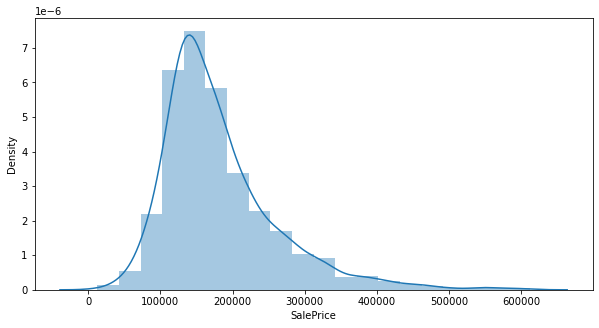

In [179]:
plt.figure( figsize = (10,5))
sns.distplot(df['SalePrice'], bins = 20)

In [180]:
Max_saleprice = df['SalePrice'].max()
print(f' Maximum price of SalePrice: {Max_saleprice}')

 Maximum price of SalePrice: 611657


In [181]:
Min_saleprice = df['SalePrice'].min()
print(f' Minumum price of SalePriceos: {Min_saleprice}')

 Minumum price of SalePriceos: 12789


In [182]:
df[df['SalePrice'] < 35000]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1554,20,A (agr),80.0,14584,Pave,0,Reg,Low,AllPub,Inside,...,0,0,NA,0,NA,0,2,2008,WD,13100
727,30,C (all),60.0,7879,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,1,NA,0,11,2009,WD,34900
182,30,RM,68.0,9656,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,6,2010,WD,12789


In [183]:
df[df['SalePrice'] < 35000]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1554,20,A (agr),80.0,14584,Pave,0,Reg,Low,AllPub,Inside,...,0,0,NA,0,NA,0,2,2008,WD,13100
727,30,C (all),60.0,7879,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,1,NA,0,11,2009,WD,34900
182,30,RM,68.0,9656,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,6,2010,WD,12789


Properties 1554 and 182 both have exceptionally low sale prices, so I will drop them as outliers.

In [184]:
df.drop(index=1554, inplace=True)
df.drop(index=182, inplace=True)

Next I want to see the distribution of SalePrice.

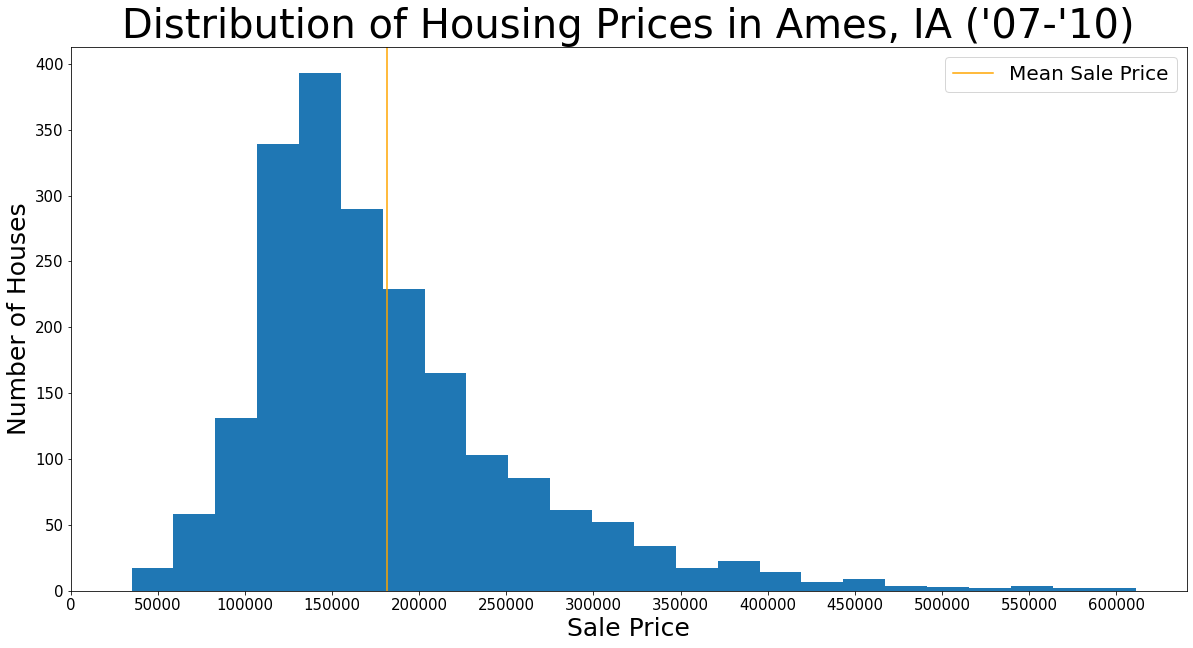

In [185]:
plt.figure(figsize=(20, 10))
plt.hist(df.SalePrice, bins=24)
plt.title("Distribution of Housing Prices in Ames, IA ('07-'10)", fontsize=40)
plt.xticks(ticks=range(0, 625000, 50000), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Sale Price', fontsize=25)
plt.ylabel('Number of Houses', fontsize=25)
plt.axvline(df.SalePrice.mean(), color='orange', label='Mean Sale Price')
plt.legend(fontsize=20);
# plt.savefig('../viz_exports/distribution.png');

The SalePrice values are right-skewed, so our model is likely to underpredict when it's incorrect. If we're using this model for the purposes of tax assessment, that means we'll be leaving money on the table if we follow the model blindly. 

This isn't a fatal flaw, but if the model goes into production it will need to be considered with that caveat.

My next step is to use histograms to examine the distribution of the other numerical features for any possible insights.

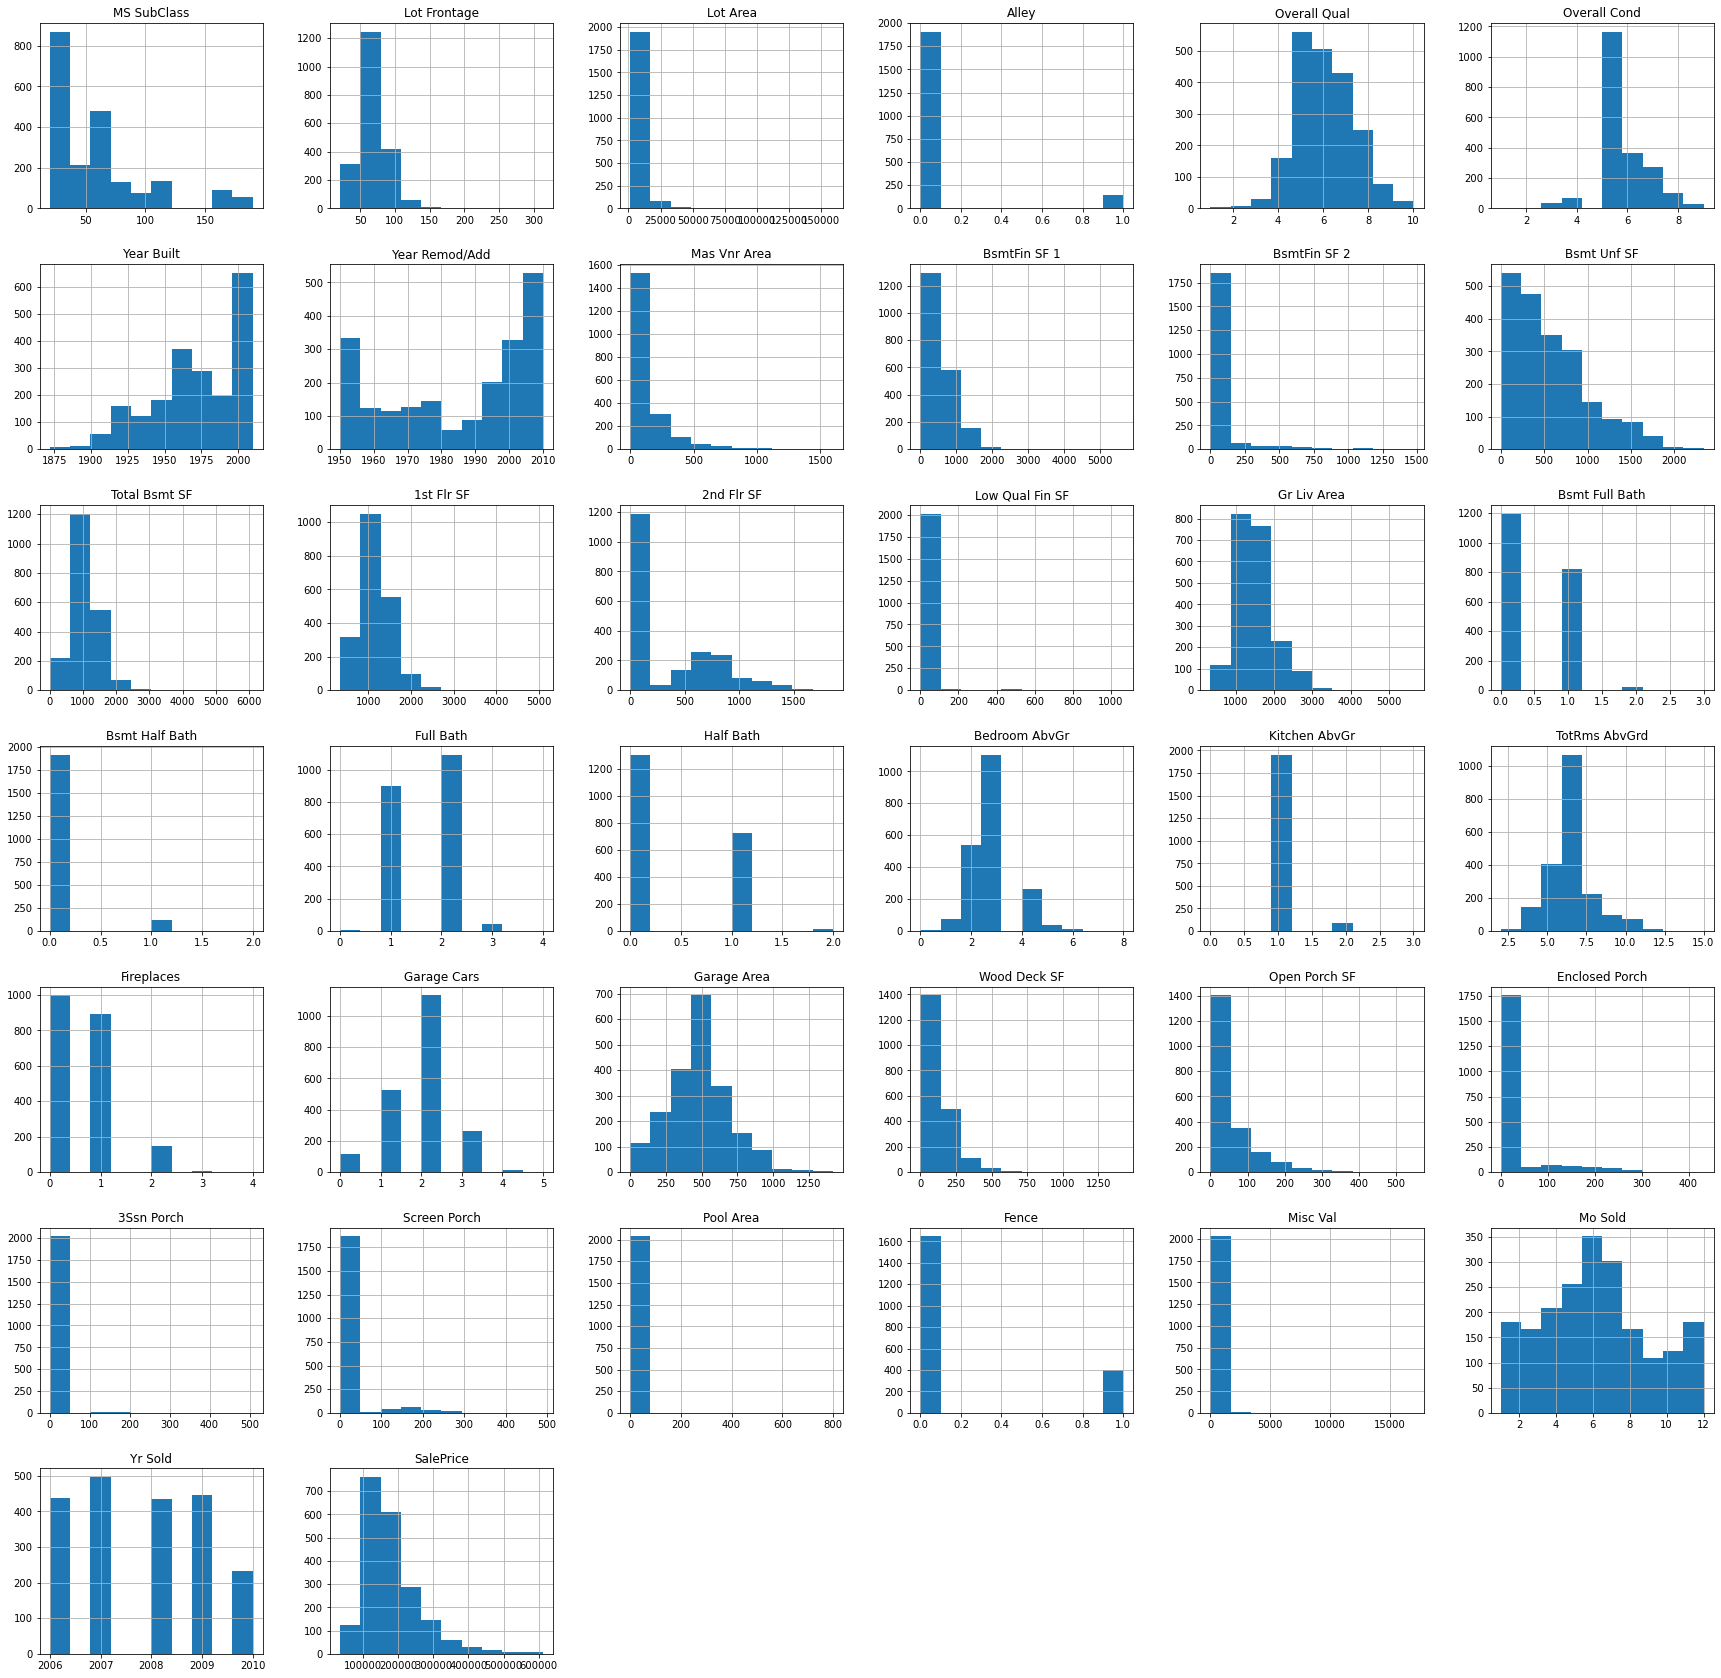

In [186]:
df.hist(figsize=(30, 30));

I want to reformat the features that are scored on a scale of 1-10. Binning them into five qualitative values should make those features more consistent predictors of price. 

I will write a function that performs this reformatting.

In [187]:
def scale_10_rewrite(column):
    for row in df.index:
        if df.loc[row, column] >= 9:
            df.loc[row, column] = str('Ex')
        elif df.loc[row, column] >= 7:
            df.loc[row, column] = str('Gd')
        elif df.loc[row, column] >= 4:
            df.loc[row, column] = str('Avg')
        elif df.loc[row, column] >= 1:
            df.loc[row, column] = str('Fa')
        else:
            df.loc[row, column] = str('Po')
    return

Now I'll pass the Overall Qual and Overall Cond features to that function and verify that it works properly.

In [188]:
scale_10_rewrite('Overall Qual')
scale_10_rewrite('Overall Cond')

df[df.columns[df.columns.str.contains('Overall')]].head()

,Overall Qual,Overall Cond
Id,,
109,Avg,Gd
544,Gd,Avg
153,Avg,Gd
318,Avg,Avg
255,Avg,Gd


In the histograms above, Garage Area and Garage Cars have very similar distributions and they deal with the same general feature, namely garage size. I'll

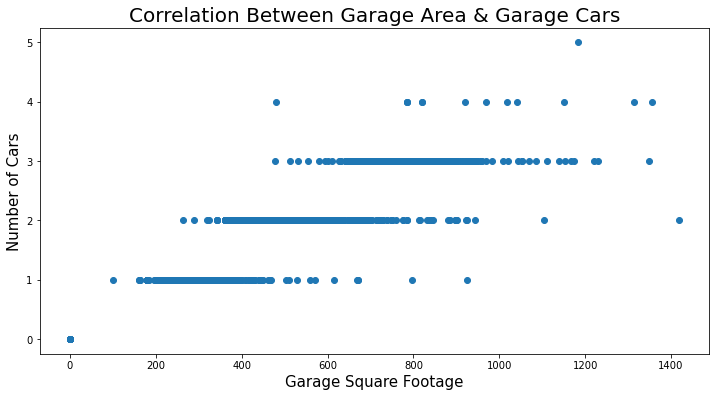

In [189]:
plt.figure(figsize=(12,6))
plt.scatter(x=df['Garage Area'], y=df['Garage Cars'])
plt.title(label='Correlation Between Garage Area & Garage Cars', fontsize=20)
plt.ylabel('Number of Cars', fontsize=15)
plt.xlabel('Garage Square Footage', fontsize=15);

Garage Area and Garage Cars are basically telling us the same thing and they appear to have a collinear relationship, so I will drop Garage Area from our dataset to avoid collinearity in those features.

In [190]:
df.drop(columns = 'Garage Area', inplace=True)

Garage Qual and Garage Cond likewise seem to overlap too much to keep both, so I'll drop Garage Cond.

In [191]:
df.drop(columns='Garage Cond', inplace=True)


Additionally, the information that is encoded in Garage Finish is likely already factored into Garage Qual so I'll drop Garage Finish and convert Garage Qual into a 4-bin category, with three quality options and a fourth for properties that have no garage.

In [192]:
df.drop(columns = 'Garage Finish', inplace = True)

df['Garage Qual'] = df['Garage Qual'].map({'Ex': 'Gd', 'Gd': 'Gd',
                                         'TA': 'TA',
                                         'Fa': 'Po', 'Po': 'Po',
                                          'NA': 'NA'})

Pool Area's distribution in the charts above looks heavily one-sided so I want to take another look at that feature.

In [193]:
df['Pool Area'].describe()

count    2045.00000
mean        2.40489
std        37.83776
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max       800.00000
Name: Pool Area, dtype: float64

Pool Area is even more skewed than I thought, so I'd like to see if Pool QC would work better as a categorical feature.

In [194]:
df['Pool QC'].value_counts()

NA    2036
Gd       4
TA       2
Fa       2
Ex       1
Name: Pool QC, dtype: int64

Indeed, there are very few properties with pools in our dataset, so I will drop Pool Area and let Pool QC stand as the heavy influencer for those properties that do have a pool.

In [195]:
df.drop(columns = 'Pool Area', inplace=True)

Heating is another feature that seems to be double-represented with Heating QC. I'll drop Heating since Heating QC is probably more informative, and I'll convert Heating QC from a 5-step quality scale to a 3-step scale.

In [196]:
df.drop(columns = 'Heating', inplace=True)

df['Heating QC'] = df['Heating QC'].map({'Ex': 'Gd', 'Gd': 'Gd',
                                         'TA': 'TA',
                                         'Fa': 'Po', 'Po': 'Po'})

I'll convert Central Air to a numeric binary column that corresponds to its current Y/N value.

I want to visualize the correlation of our remaining numeric values with SalePrice.

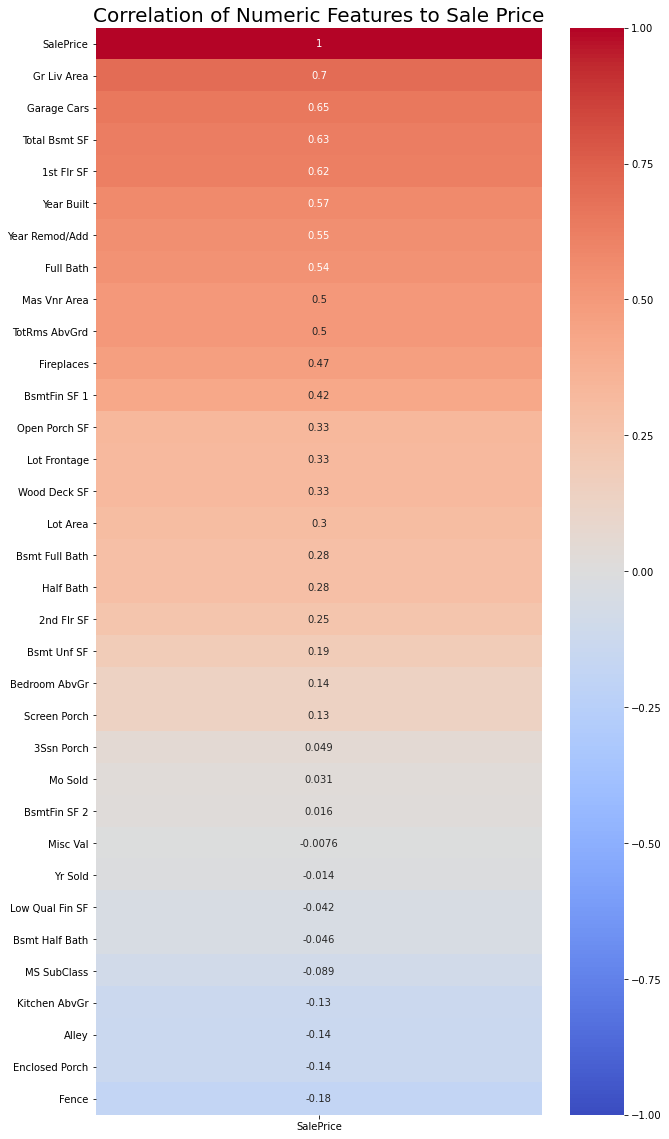

In [197]:
plt.figure(figsize=(10,20))
sns.heatmap(df.corr()[['SalePrice']].sort_values('SalePrice', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(label='Correlation of Numeric Features to Sale Price', fontsize=20);

Mo Sold, BsmtFin SF 2, Misc Val, and Yr Sold all have almost no correlation with SalePrice, so I'll drop those features.

In [198]:
df.drop(columns=['Mo Sold', 'BsmtFin SF 2', 'Misc Val', 'Yr Sold'], inplace=True)

In [199]:
df.shape

(2045, 68)

In [200]:
numeric_col = df.describe().columns
print(numeric_col)
print(f' Num_Features: {len(numeric_col)}')

Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Alley', 'Year Built',
       'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'Bsmt Unf SF',
       'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Cars', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Fence', 'SalePrice'],
      dtype='object')
 Num_Features: 30


In [201]:
categorical_col = df.columns.drop(numeric_col)
print(categorical_col)
print(f' Cat_Features: {len(categorical_col)}')

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Central Air',
       'Electrical', 'Kitchen Qual', 'Functional', 'Garage Type',
       'Garage Qual', 'Paved Drive', 'Pool QC', 'Misc Feature', 'Sale Type'],
      dtype='object')
 Cat_Features: 38


### One-Hot Encoding

Before I go any further I will dummy out the qualitative features in the dataset. I won't be able to model on non-numeric features so this command will expand each qualitative feature into a group of binary features for each possible value in the original column.

In [202]:
df_dummies = pd.get_dummies(df)

In [203]:
df_dummies.shape

(2045, 272)

Now that the values in the dataframe are entirely numeric, I can begin modeling on it.

### Modeling

## Train-Test-Split & Scale

Now that I'm done preparing the dataframe, I will first split it into X and y. The y values will be the values from SalePrice. These represent our targets. And X will contain all of the non-price features.

In [204]:
X=df_dummies.drop(columns='SalePrice')
y=df_dummies.SalePrice


Now I will split both X and y into a training set and a test set. This allows me to model on only the training portion of the data and evaluate the model's performance on data that it has not seen.

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

Lastly I will instantiate the StandardScaler and use it to scale the X training data. This will normalize the values in X so that features like square footage (which could have values in the thousands) won't have disproportionate weight in the model compared to features like Garage Cars that will max out in the single digits, or the dummy features which can only be 0 or 1. That same transformation will then be applied to the X testing data.

In [206]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Comparing Models

Before pursuing a production model I will run cross-validation tests on the dataset with linear regression, lasso CV, and ridge CV models. The cross-validation tests will apply a version of each model to five different splits of the dataset and average the results. The type of model that returns the best score will be the most promising for my purposes.

First I will instantiate all three models.

In [207]:
lr = LinearRegression()
lasso = LassoCV(cv=5)
ridge = RidgeCV(cv=5)

Next I will calculate and print the cross-validation scores of the three models.

In [208]:
print(f'Linear Regression: {cross_val_score(lr, X_train_sc, y_train, cv=5).mean()}')
print(f'Lasso: {cross_val_score(lasso, X_train_sc, y_train, cv=5).mean()}')
print(f'Ridge: {cross_val_score(ridge, X_train_sc, y_train, cv=5).mean()}')

Linear Regression: -7.550368398628938e+24
Lasso: 0.8382880201322246
Ridge: 0.8126031657199831


Linear regression is returning a terrible score, most likely because there are still so many features being used in the model. Ridge and lasso are returning much better scores because they are reducing or eliminating the effect of collinear features, respectively. Since the lasso model is slightly better I will proceed with it by fitting a lasso model to the training set and finding its r2 score on the training set.

In [209]:
lasso.fit(X_train_sc, y_train)

lasso.score(X_train_sc, y_train)

0.9338390081314545

Since r2 scores range from 0 to 1, a score of .931 is great. This means that over 93% of the variance in SalePrice can be explained by the model. That's a great training score, but now I need to see how the model performs with the test split to make sure the model wasn't just overfit to the training data.

In [210]:
preds = lasso.predict(X_test_sc)

(mean_squared_error(y_test, preds)) ** .5

20299.975445594948

This is a pretty good RMSE score. It means that on average the model will predict within $20,299.98 of the actual target. Now I'll plot those predictions against the actual prices for those properties so the strength of the model can be judged visually.

In [211]:
df['SalePrice'].median()

162500.0

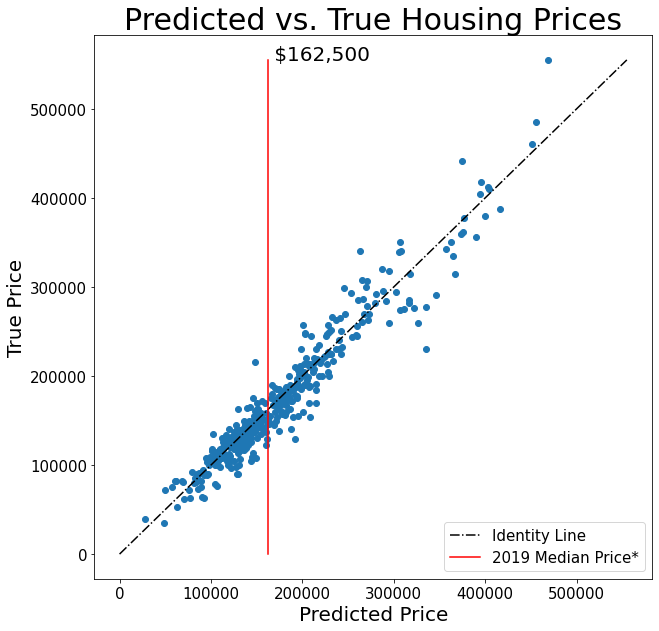

In [212]:
plt.figure(figsize=(10,10))

plt.scatter(preds, y_test, label=None)
plt.plot((0, y_test.max()), (0,y_test.max()), 'k-.', label='Identity Line')
plt.plot((162500.0, 162500.0), (0,y_test.max()), 'r-', label='2019 Median Price*')

plt.title('Predicted vs. True Housing Prices', fontsize=30)
plt.xlabel('Predicted Price', fontsize=20)
plt.ylabel('True Price', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.annotate(' $162,500', (162500,y_test.max()), fontsize=20)
plt.legend(fontsize=15, loc='lower right');

Despite the starting strength of the model, I want to do just a little tuning. I'll pickle the model, scaler, and a list of the dummied column names to use for the next step and I'll export the dummied CSV as well.

In [213]:
with open('./datasets/lasso_lin_reg.pkl', 'wb+') as f:
     pickle.dump(lasso, f)
with open('./datasets/scaler.pkl', 'wb+') as f:
     pickle.dump(ss, f)
with open('./datasets/columns.pkl', 'wb+') as f:
     pickle.dump(list(df_dummies.columns), f)
        
df_dummies.to_csv('./datasets/train_clean_dummies.csv')

All the data should be ready to go in Notebook #3.

## Model Tuning

In [214]:
with open('./datasets/lasso_lin_reg.pkl', 'rb') as f:
    lasso = pickle.load(f)
with open('./datasets/scaler.pkl', 'rb') as f:
    ss = pickle.load(f)
with open('./datasets/columns.pkl', 'rb') as f:
    columns = pickle.load(f)

ames_dummies = './datasets/train_clean_dummies.csv'
df = pd.read_csv(ames_dummies, index_col='Id', keep_default_na=False)

I want to examine the model a little more closely. I'll start by printing the model's alpha value.

In [215]:
lasso.alpha_

687.5903280095314

This is a very high alpha value, which indicates that the model's regularization was very aggressive. We can visualize this impact with a histogram.

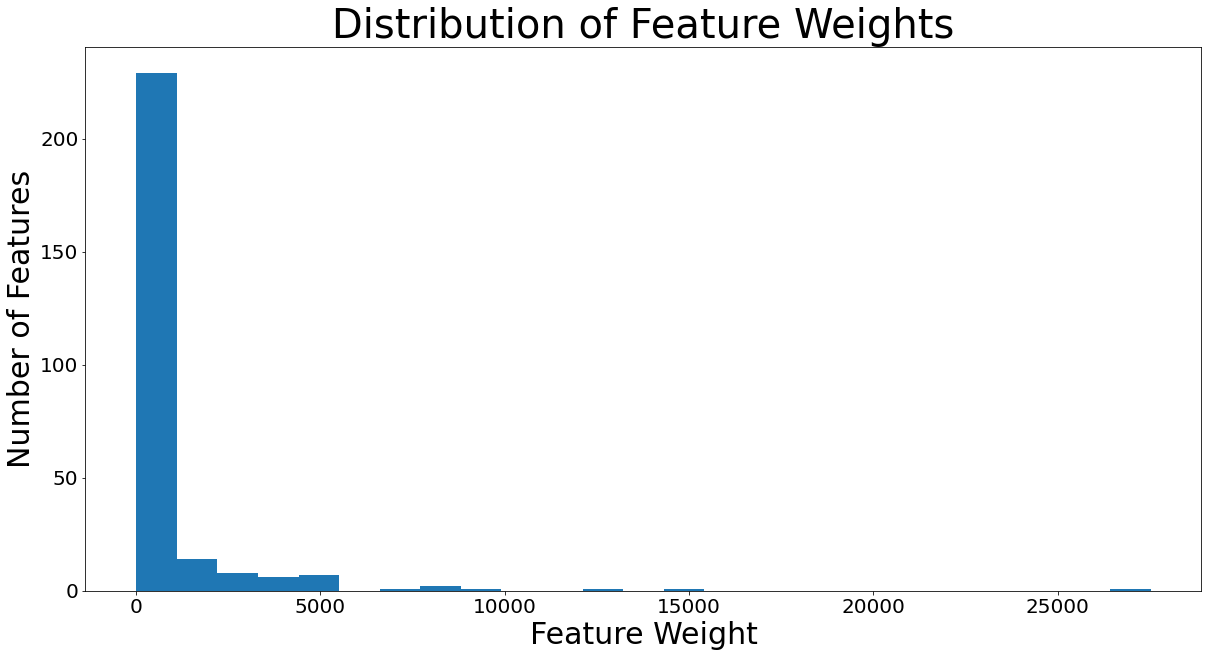

In [216]:
plt.figure(figsize=(20, 10))

plt.title('Distribution of Feature Weights', fontsize=40)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Weight', fontsize=30)
plt.ylabel('Number of Features', fontsize=30)

plt.hist(np.sort(abs(lasso.coef_)), bins=25);

From this histogram we can see that the model reduced the vast majority of features to zero weight on the predictions.

I want to plot the model's intercept and its most influential beta coefficients to evaluate whether or not the model makes logical human sense. To do that, I'll first have to remove SalePrice from the imported list of columns since those values were not present in the training data on which the model was based.

In [217]:
columns.remove('SalePrice')

Now I'll plot the model's intercept and its most influential beta coefficients to evaluate whether or not the model makes logical human sense.

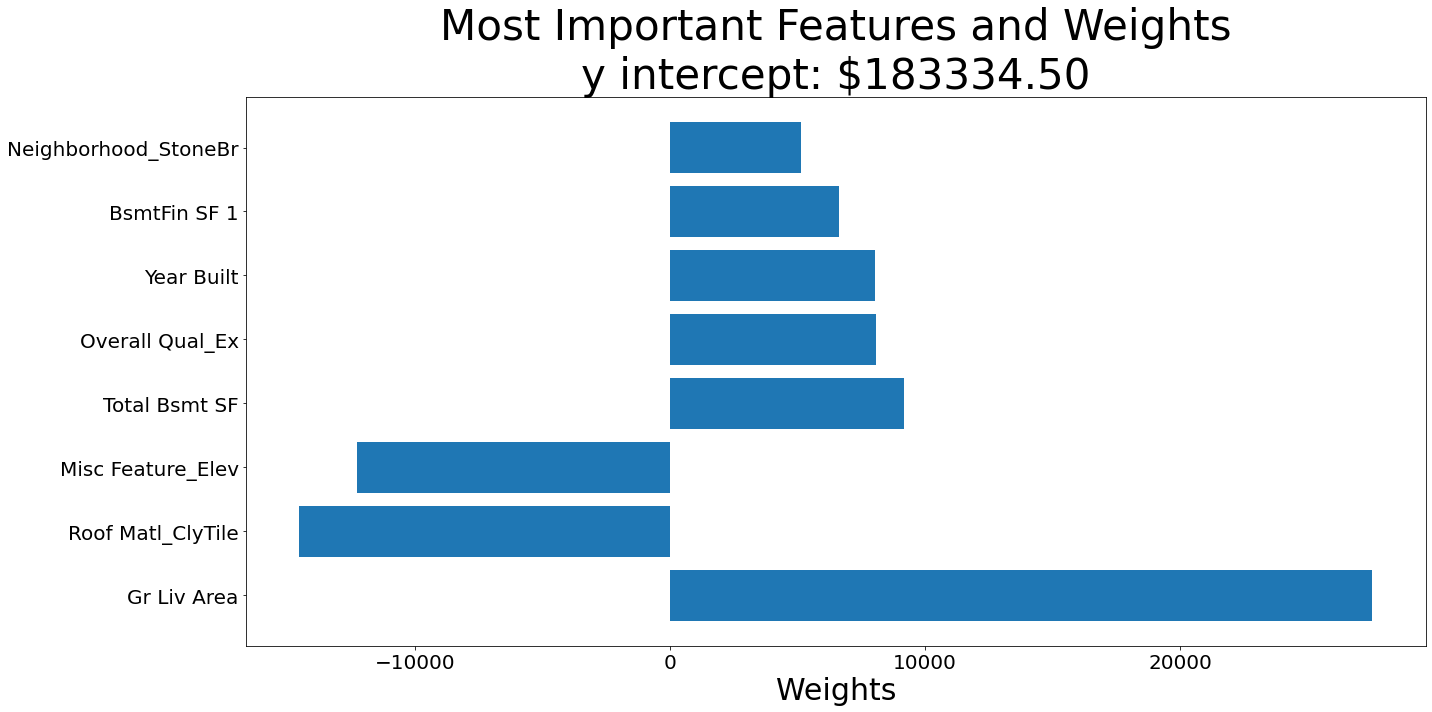

In [218]:
beta_0 = lasso.intercept_

betas = pd.DataFrame({'weights' : lasso.coef_, 'features' : columns})
betas.set_index(betas.features, inplace=True)

betas['abs_w'] = betas.weights.abs()
betas.head()

weights = betas.sort_values('abs_w', ascending=False)['weights'].head(8)
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${beta_0:0.02f}', fontsize=42)
plt.tight_layout()



It's strange that Misc Feature_Elev and Roof Matl_ClyTile have such an outsized negative impact on price in this model. I need to pull in the training dataset to see what might be creating that weight in the properties with those features.

In [219]:
ames_raw = pd.read_csv('./datasets/train.csv')
ames_raw.loc[(ames_raw['Misc Feature'] == 'Elev')]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1885,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,0,NaN,NaN,Elev,17000,10,2007,New,183850


A close look at this entry raises questions. It's a new home on a very large lot, so it should be a highly-valued property. We can infer either that there was human error in entering this property's data, or that there are some other extenuating circumstances surrounding this property that drove down its sale price. In any event, for the purposes of modeling it makes the most sense to eliminate this property from our training set.

In [220]:
df.drop(index=2181, inplace=True)

Next I want to take a look at the property with the clay tile roof.

In [221]:
ames_raw.loc[(ames_raw['Roof Matl'] == 'ClyTile')]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
960,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,0,480,Gd,NaN,NaN,0,1,2008,New,160000


This property also seems to be an outlier, so the model would be best served by dropping it from the training set.

In [222]:
df.drop(index=1499, inplace=True)

Now that the offending properties have been removed from the training data, I will split and scale the data again, and then fit a new lasso model to it. This new model should perform better than the original one.

In [223]:
X=df.drop(columns='SalePrice')
y=df.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

lasso = LassoCV(cv=5)

lasso.fit(X_train_sc, y_train);

The model is now fit to the revised training data and I can get its new training score.

In [224]:
lasso.score(X_train_sc, y_train)

0.9401184953547871

This new training score marks a slight improvement over the original model. Now I will get its test score.

In [225]:
lasso.score(X_test_sc, y_test)

0.9138893795061512

This score is only very slightly worse than the original model, which was better by only .002. I'll check the new model's RMSE for more insight.

In [226]:
preds = lasso.predict(X_test_sc)
(mean_squared_error(y_test, preds)) ** .5

22420.1440026713

The new RMSE score is an improvement over the original. Here is a visualization of the new model's predictions compared to their targets.

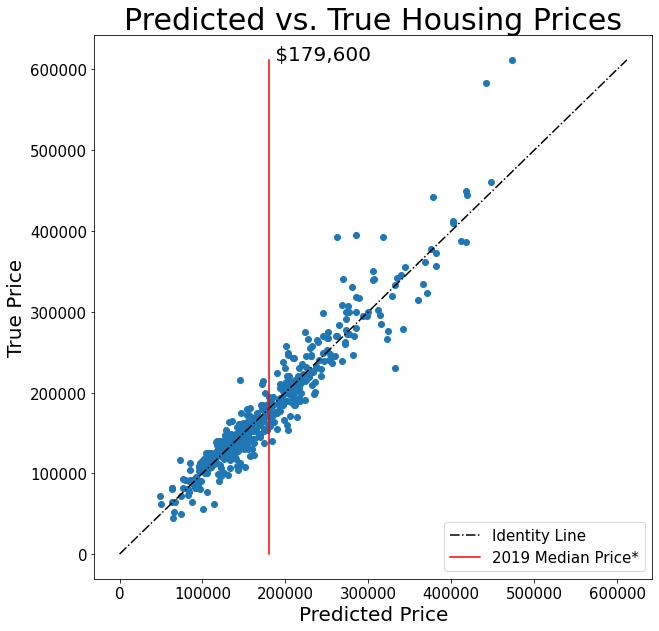

In [227]:
plt.figure(figsize=(10,10))
plt.scatter(preds, y_test, label=None)
plt.plot((0, y_test.max()), (0,y_test.max()), 'k-.', label='Identity Line')
plt.plot((179600, 179600), (0,y_test.max()), 'r-', label='2019 Median Price*')
plt.title('Predicted vs. True Housing Prices', fontsize=30)
plt.xlabel('Predicted Price', fontsize=20)
plt.ylabel('True Price', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.annotate(' $179,600', (179600,y_test.max()), fontsize=20)
plt.legend(fontsize=15, loc='lower right');

At the moment I'm happy with the new model's results but I want to plot the weights of its coefficients first to make sure there aren't any anomalies in it like the elevator or clay tile roof from earlier.

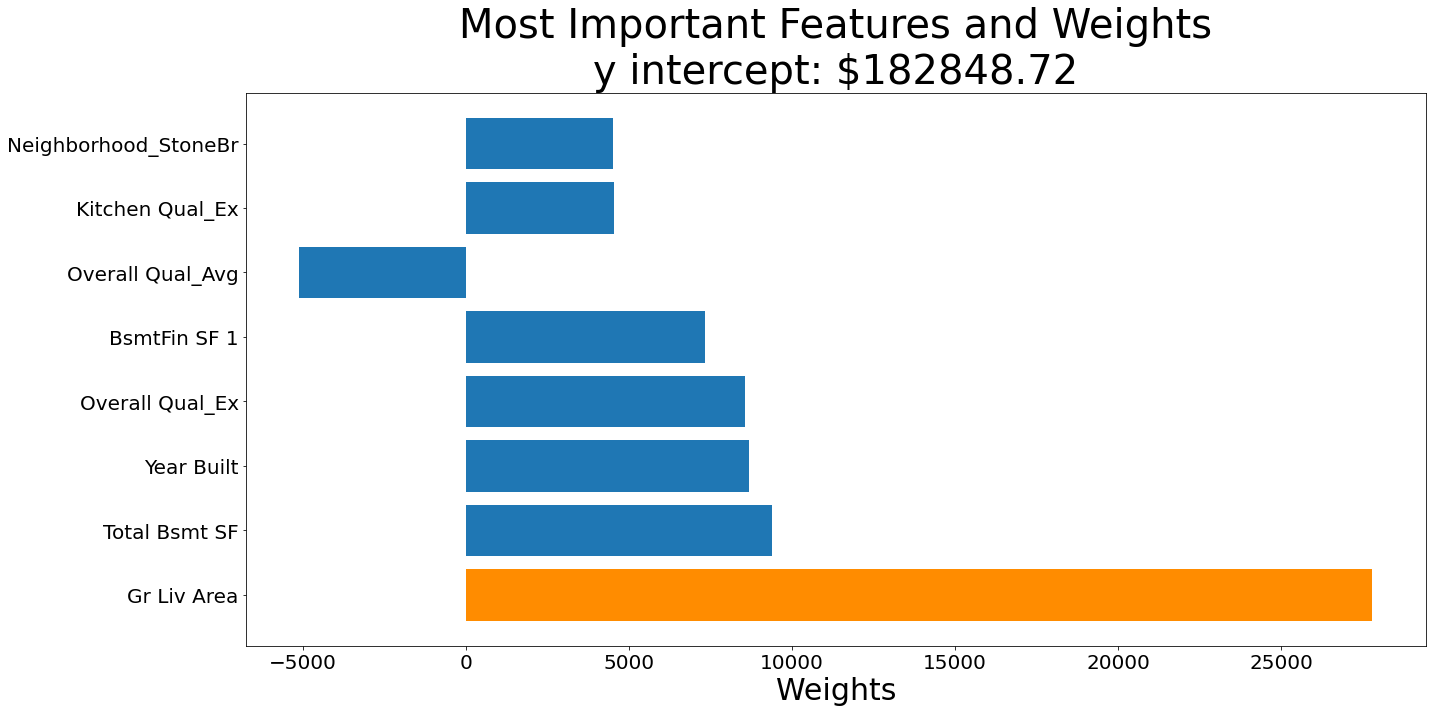

In [228]:
v2_beta_0 = lasso.intercept_
v2_betas = pd.DataFrame({'weights' : lasso.coef_, 'features' : columns})
v2_betas.set_index(v2_betas.features, inplace=True)

v2_betas['abs_w'] = v2_betas.weights.abs()

v2_weights = v2_betas.sort_values('abs_w', ascending=False)['weights'].head(8)
labels = v2_weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, v2_weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${v2_beta_0:0.02f}', fontsize=40)
plt.barh('Gr Liv Area', v2_weights['Gr Liv Area'], color='darkorange')
plt.tight_layout()

The fact that Overall Qual_Avg has that negative of an impact on the price prediction is odd. But the rest of the most important features and their relative impact make sense, and the model is scoring well. I'll create another visualization with an expanded set of important features to see if any other curiosities appear.

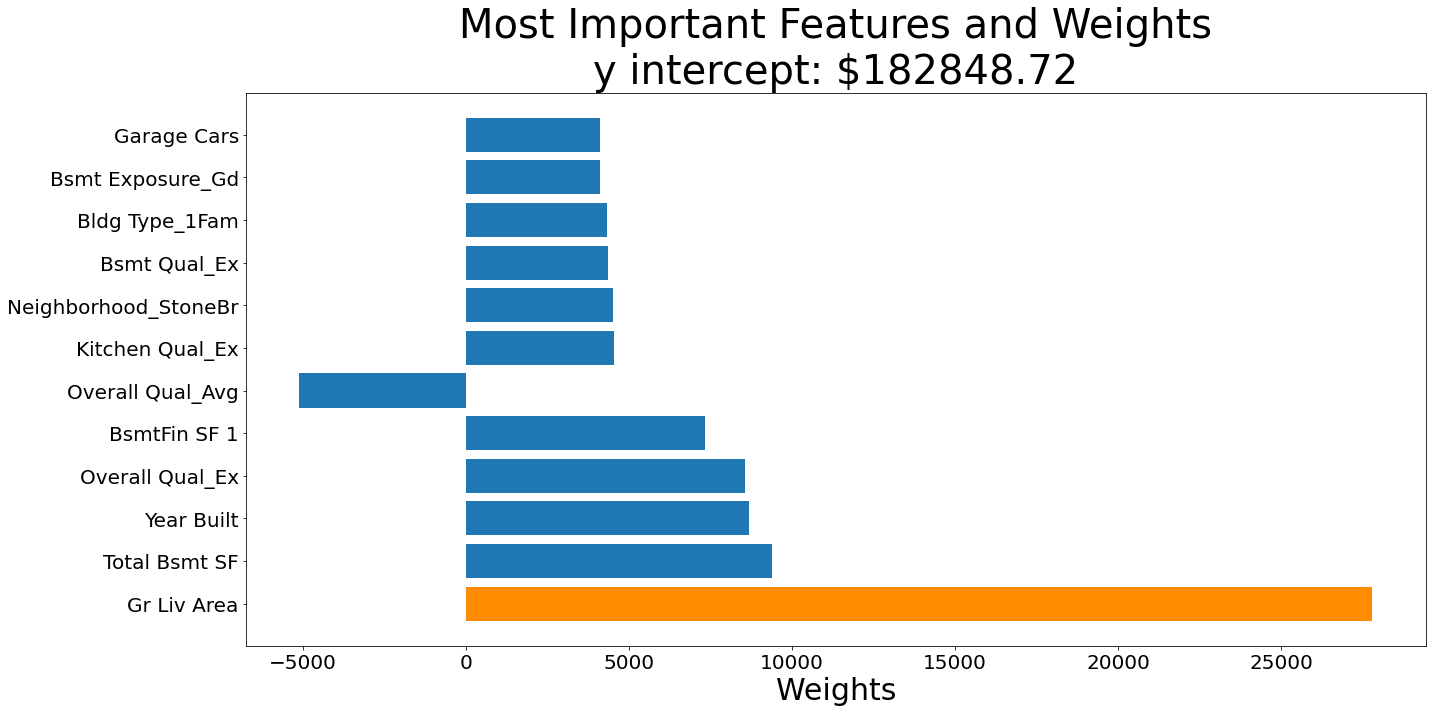

In [229]:
v2_weights = v2_betas.sort_values('abs_w', ascending=False)['weights'].head(12)
labels = v2_weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, v2_weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${v2_beta_0:0.02f}', fontsize=40)
plt.barh('Gr Liv Area', v2_weights['Gr Liv Area'], color='darkorange')
plt.tight_layout()


The next four most important features include having an excellent-quality basement, being a detached single-family home, good basement exposure, and the number of cars the garage holds. It makes sense that these would have a reasonably positive impact on price, so instead of disrupting the model I'll let it stand and move on to using it for predictions.

In the following code block I'll pickle the model and scaler for use in making online predictions.

In [230]:
with open('./datasets/lasso_lin_reg.pkl', 'wb+') as f:
     pickle.dump(lasso, f)
    
with open('./datasets/scaler.pkl', 'wb+') as f:
     pickle.dump(ss, f)

# My last version of Kaggle Submission

### Importing and Cleaning the Validation Dataset

To get started, I'll bring in the model and scaler created in the previous phase of the project.

In [231]:
with open('./datasets/lasso_lin_reg.pkl', 'rb') as f:
    lasso = pickle.load(f)
with open('./datasets/scaler.pkl', 'rb') as f:
    ss = pickle.load(f)
    
kaggle = pd.read_csv('./datasets/test.csv', index_col='Id')

Next I'll apply to the validation set all the transformations that I applied to the training dataset in the cleaning and EDA notebooks. 

Note that Lot Frontage will be filled with the value 69.059406, which was the mean value used to fill that feature's null values in the training set.

In [232]:
kaggle.drop(columns='PID', inplace=True)
kaggle['Pool QC'].fillna('NA', inplace=True)
kaggle['Misc Feature'].fillna('NA', inplace=True)

fence_quality = ['MnPrv', 'GdPrv', 'GdWo', 'MnWw']
for quality in fence_quality:
    kaggle.Fence = kaggle.Fence.str.replace(quality, '1')
kaggle.Fence.fillna(0, inplace=True)
kaggle.Fence = kaggle.Fence.apply(lambda x: int(x))

alley_quality = ['Grvl', 'Pave']
for quality in alley_quality:
    kaggle.Alley = kaggle.Alley.str.replace(quality, '1')
kaggle.Alley.fillna(0, inplace=True)
kaggle.Alley = kaggle.Alley.apply(lambda x: int(x))

kaggle.drop(columns='Fireplace Qu', inplace=True)
kaggle.drop(columns = 'Garage Yr Blt', inplace=True)

kaggle['Garage Type'].fillna('NA', inplace=True)
kaggle['Garage Finish'].fillna('NA', inplace=True)
kaggle['Garage Qual'].fillna('NA', inplace=True)
kaggle['Garage Cond'].fillna('NA', inplace=True)

def fill_basement_nulls(data):
    for row in data.index:
        if data.loc[row, 'Total Bsmt SF'] == 0:
            data.loc[row, 'Bsmt Qual'] = 'NA'
            data.loc[row, 'Bsmt Cond'] = 'NA'
            data.loc[row, 'Bsmt Exposure'] = 'NA'
            data.loc[row, 'BsmtFin Type 1'] = 'NA'
            data.loc[row, 'BsmtFin Type 2'] = 'NA'
    return
fill_basement_nulls(kaggle)

kaggle['Mas Vnr Area'].fillna(0, inplace=True)
kaggle['Mas Vnr Type'].fillna('None', inplace=True)
kaggle['Lot Frontage'].fillna(value=69.059406, inplace=True)


def scale_10_rewrite(column):
    for row in kaggle.index:
        if kaggle.loc[row, column] >= 9:
            kaggle.loc[row, column] = str('Excellent')
        elif kaggle.loc[row, column] >= 7:
            kaggle.loc[row, column] = str('Good')
        elif kaggle.loc[row, column] >= 4:
            kaggle.loc[row, column] = str('Average')
        elif kaggle.loc[row, column] >= 1:
            kaggle.loc[row, column] = str('Fair')
        else:
            kaggle.loc[row, column] = str('Poor')
    return
scale_10_rewrite('Overall Qual')
scale_10_rewrite('Overall Cond')
kaggle.drop(columns = 'Garage Area', inplace=True)
kaggle.drop(columns='Garage Cond', inplace=True)
kaggle.drop(columns = 'Pool Area', inplace=True)
kaggle.drop(columns = 'Garage Finish', inplace = True)

kaggle.drop(columns = 'Heating', inplace=True)
kaggle['Heating QC'] = kaggle['Heating QC'].map({'Ex': 'Gd', 'Gd': 'Gd',
                                                 'TA': 'TA',
                                                 'Fa': 'Po', 'Po': 'Po'})
kaggle['Central Air'] = kaggle['Central Air'].map({'Y': int(1), 'N': int(0)})
kaggle['Garage Qual'] = kaggle['Garage Qual'].map({'Ex': 'Gd', 'Gd': 'Gd',
                                                   'TA': 'TA',
                                                   'Fa': 'Po', 'Po': 'Po',
                                                   'NA': 'NA'})

With all the transformations applied, I'll check for any remaining null values that hadn't occurred in the training set.

In [233]:
kaggle.isnull().sum().sort_values(ascending=False).head()

Electrical        1
MS SubClass       0
Bsmt Full Bath    0
Kitchen Qual      0
Kitchen AbvGr     0
dtype: int64

In [234]:
kaggle.Electrical.value_counts()

SBrkr    814
FuseA     48
FuseF     15
FuseP      1
Name: Electrical, dtype: int64

With over 90% of the values in Electrical being the same, I feel comfortable imputing the mode of "SBrkr" for the missing value.

In [235]:
kaggle.Electrical.fillna('SBrkr', inplace=True)

The Electrical null has been filled, so I'll verify that the dataframe is clean before moving on to column transformations.

In [236]:
kaggle.isnull().sum().sum()

0

## Matching Columns

Before applying the scaler and model, I have to make sure the validation set has the same columns that were used to create the model with the training set. First I'll create a new dataframe with all of the validation set's columns dummied out.

In [237]:
kaggle_dummies = pd.get_dummies(kaggle)


The properties in the validation set likely have some qualitative values that didn't appear in the training set and vice-versa. So next I'll import the dummied training dataset and drop SalePrice from it so I can match the validation set's columns to it.



In [238]:
ames_dummies = './datasets/train_clean_dummies.csv'

X_train = pd.read_csv(ames_dummies, index_col='Id')
X_train.drop(columns='SalePrice', inplace=True)

Now I'll create a set containing the names of the training columns that don't appear in the validation dataframe, and I'll interate through that set with a for loop to add each column to the validation dataframe with values of 0.

In [239]:
missing_cols = set(X_train).difference(kaggle_dummies)

for col in missing_cols:
    kaggle_dummies[col] = 0

In [240]:
kaggle_dummies.shape

(879, 292)

Now that the validation set contains all of the training set's columns, I'll set it to equal the training set's columns. This will eliminate any extra features in the validation set and properly set the order of its columns to be in full compliance with the training set.

In [241]:
kaggle_dummies = kaggle_dummies[X_train.columns]

The validation dataset is ready for the scaler and model.

### Scaling and Predicting the validation Dataset

In [242]:
kaggle_sc = ss.transform(kaggle_dummies)

In [243]:
preds = lasso.predict(kaggle_sc)

### Exporting the submission


I will create a submission dataframe from the predictions. The dataframe will have an index column of the Id for each property, and a column of SalePrice with the corresponding price predictions for each property.

In [244]:
submission = pd.DataFrame(preds, index=kaggle.index, columns=['SalePrice'])
submission.head()

,SalePrice
Id,
2658,128071.453817
2718,180666.419481
2414,212790.251565
1989,118975.410064
625,187680.028315


Before exporting I'll sort the dataframe in ascending order by its Id index.

In [245]:
submission.sort_index(inplace=True)
submission.head()

,SalePrice
Id,
2,124359.497218
4,280730.426514
6,198731.131825
7,217359.182990
17,196408.110405


Finally, I will export this sorted dataset of predictions to a new CSV file for submission to Kaggle. I've left the command for this export commented out to protect against an accidental overwrite of earlier predictions.

In [127]:
#submission.to_csv('./datasets/kaggle_final_submission_2.csv')